In [1]:
import pandas as pd
import re
import string
import spacy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
# One-hot encode labels
label_dict = {'positive': 1, 'negative': 0}
df['sentiment'] = df['sentiment'].map(label_dict)

In [5]:
# Text preprocessing functions
def clean_text(text):
    # Remove URLs, HTML tags, and unwanted characters
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()


In [6]:
# Function to tokenize and preprocess text
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])  # Load spaCy English model

In [7]:
def tokenize_and_preprocess(text):
    doc = nlp(text)  # Tokenize text with spaCy
    tokens = [token.lemma_ for token in doc if not token.is_stop]  # Lemmatization and remove stopwords
    return ' '.join(tokens)

In [8]:
# Apply preprocessing to DataFrame
df['processed_text'] = df['review'].apply(lambda x: tokenize_and_preprocess(clean_text(x)))

In [9]:
df['processed_text']

0        reviewer mention watch 1 oz episode ll hook ri...
1        wonderful little production film technique una...
2        think wonderful way spend time hot summer week...
3        basically s family little boy Jake think s zom...
4        Petter Matteis Love Time Money visually stunni...
                               ...                        
49995    think movie right good job not creative origin...
49996    bad plot bad dialogue bad act idiotic direct a...
49997    Catholic teach parochial elementary school nun...
49998    m go disagree previous comment Maltin second r...
49999    expect Star Trek movie high art fan expect mov...
Name: processed_text, Length: 50000, dtype: object

In [10]:
# Tokenize processed texts
max_words = 1000  # Maximum number of words to tokenize
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['processed_text'])

In [11]:
# Convert texts to sequences of integers
sequences = tokenizer.texts_to_sequences(df['processed_text'])

In [12]:
# Pad sequences to ensure uniform length
max_seq_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length)

In [13]:
X = pad_sequences(sequences, maxlen=max_seq_length)
y = df['sentiment'].values

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


### RNN Model

In [14]:
# Define the RNN model
embedding_dim = 16
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    Bidirectional(LSTM(64, return_sequences=True)),  
    LSTM(32, return_sequences=False),  
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  ])

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Training the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 232s 184ms/step - accuracy: 0.7518 - loss: 0.4772 - val_accuracy: 0.8552 - val_loss: 0.3501
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 235s 188ms/step - accuracy: 0.8565 - loss: 0.3390 - val_accuracy: 0.8539 - val_loss: 0.3403
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1916s 2s/step - accuracy: 0.8661 - loss: 0.3184 - val_accuracy: 0.8583 - val_loss: 0.3243
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 234s 187ms/step - accuracy: 0.8731 - loss: 0.3015 - val_accuracy: 0.8527 - val_loss: 0.3356
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 235s 188ms/step - accuracy: 0.8762 - loss: 0.2949 - val_accuracy: 0.8547 - val_loss: 0.3294
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 235s 188ms/step - accuracy: 0.8803 - loss: 0.2855 - val_accuracy: 0.8616 - val_loss: 0.3251
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 235s 188ms/step - accuracy: 0.8878 - loss: 0.2779 - val_accuracy: 0.8586 - val_loss: 0.3495
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 237s 190ms/step - accu

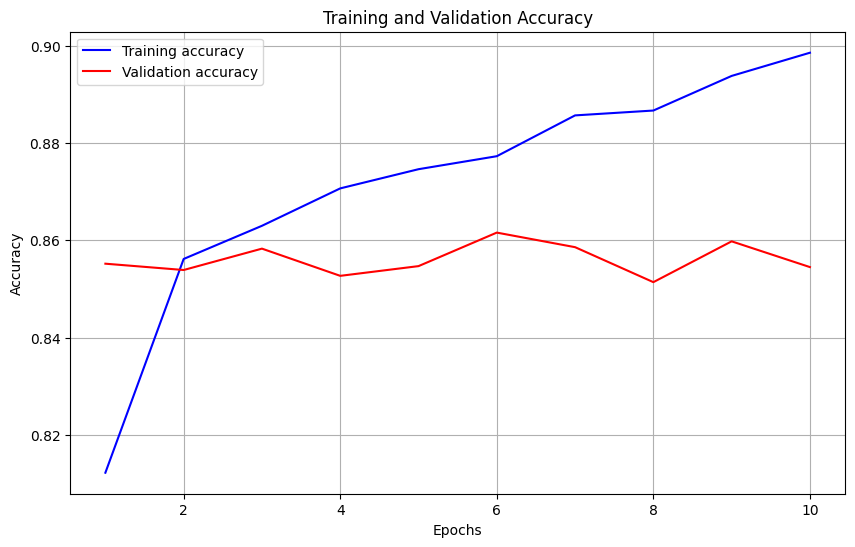

In [20]:
# Extracting training and validation accuracy from history
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plotting training and validation accuracy
epochs = range(1, len(training_acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc, 'b', label='Training accuracy')
plt.plot(epochs, validation_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

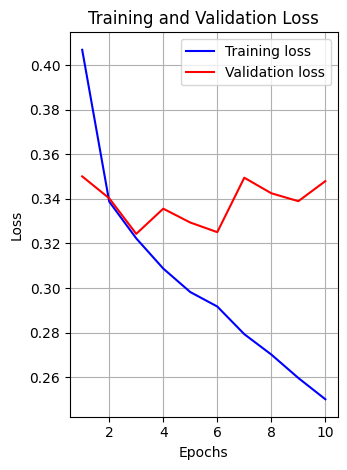

In [21]:
# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss, 'b', label='Training loss')
plt.plot(epochs, validation_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [28]:
# Example prediction
new_reviews = ["This movie was wonderful and exciting!", "The film was terrible and I fell asleep."]
new_reviews_clean = [tokenize_and_preprocess(clean_text(review)) for review in new_reviews]
new_sequences = tokenizer.texts_to_sequences(new_reviews_clean)
new_padded = pad_sequences(new_sequences, maxlen=max_seq_length)
predictions = model.predict(new_padded)
predictions = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
['positive', 'negative']
